Ant Colony Optimization for Network Routing

Network created with 8 nodes
Total edges: 13

Searching for optimal path: Node 0 → Node 7
Running 50 iterations...

Iteration 0: Path = 0 → 1 → 2 → 3 → 4 → 6 → 7, Delay = 13.00
Iteration 10: Path = 0 → 1 → 2 → 3 → 4 → 6 → 7, Delay = 13.00
Iteration 20: Path = 0 → 1 → 2 → 3 → 4 → 6 → 7, Delay = 13.00
Iteration 30: Path = 0 → 1 → 2 → 3 → 4 → 6 → 7, Delay = 13.00
Iteration 40: Path = 0 → 1 → 2 → 3 → 4 → 6 → 7, Delay = 13.00

RESULTS
Best path found: 0 → 1 → 2 → 3 → 4 → 6 → 7
Total delay: 13.00
Number of hops: 6

Generating visualizations...


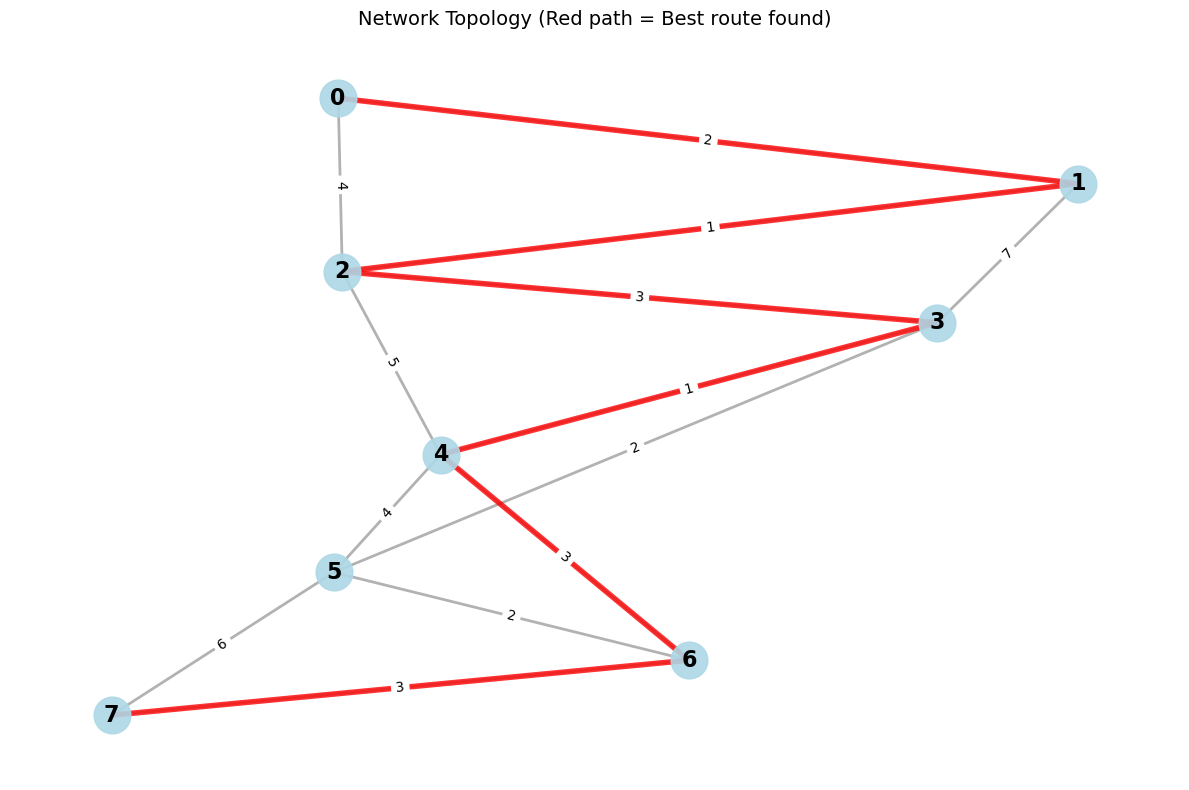

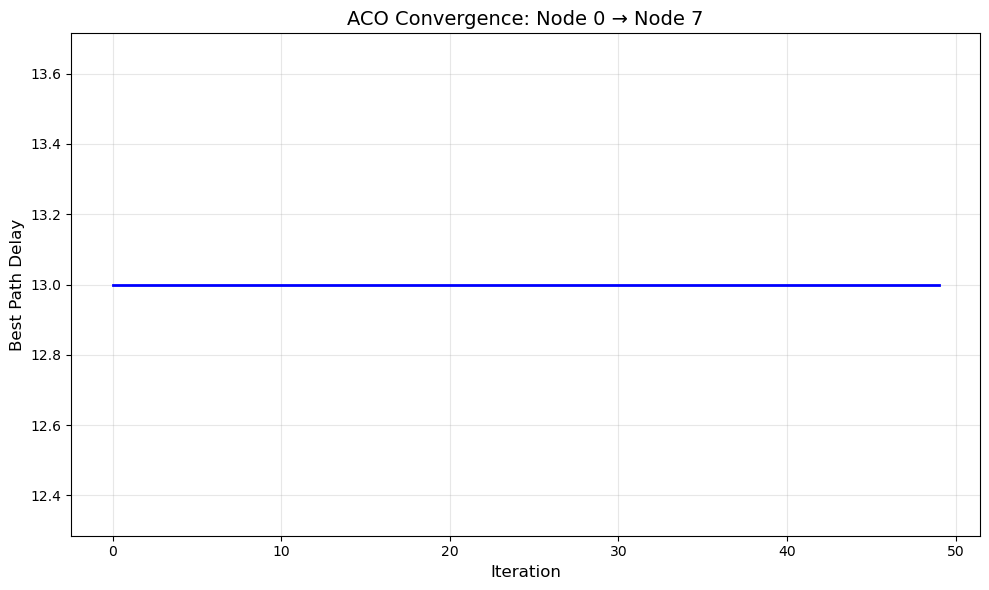


Simulation complete!


In [1]:
import random
import math
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx

class NetworkNode:
    """Represents a router/node in the network"""
    def __init__(self, node_id):
        self.node_id = node_id
        self.pheromone_table = defaultdict(lambda: defaultdict(float))
        self.routing_table = defaultdict(lambda: defaultdict(float))
        self.neighbors = []
        
    def initialize_pheromones(self, destination, neighbors, initial_value=0.1):
        """Initialize pheromone values for a destination"""
        for neighbor in neighbors:
            self.pheromone_table[destination][neighbor] = initial_value
            self.routing_table[destination][neighbor] = 1.0 / len(neighbors)

class NetworkGraph:
    """Represents the network topology"""
    def __init__(self):
        self.nodes = {}
        self.edges = {}
        self.delays = {}
        
    def add_node(self, node_id):
        """Add a node to the network"""
        if node_id not in self.nodes:
            self.nodes[node_id] = NetworkNode(node_id)
            
    def add_edge(self, node1, node2, delay=1.0):
        """Add a bidirectional edge with delay"""
        self.add_node(node1)
        self.add_node(node2)
        
        self.edges[(node1, node2)] = delay
        self.edges[(node2, node1)] = delay
        self.delays[(node1, node2)] = delay
        self.delays[(node2, node1)] = delay
        
        if node2 not in self.nodes[node1].neighbors:
            self.nodes[node1].neighbors.append(node2)
        if node1 not in self.nodes[node2].neighbors:
            self.nodes[node2].neighbors.append(node1)
            
    def get_delay(self, node1, node2):
        """Get the delay between two nodes"""
        return self.delays.get((node1, node2), float('inf'))

class Ant:
    """Represents a forward ant packet"""
    def __init__(self, source, destination):
        self.source = source
        self.destination = destination
        self.path = [source]
        self.total_delay = 0.0
        self.visited = {source}
        
    def select_next_node(self, current_node, network, alpha=1.0, beta=2.0):
        """Select next node based on pheromone and heuristic info"""
        node = network.nodes[current_node]
        neighbors = node.neighbors
        
        # Filter out already visited neighbors (avoid loops)
        available_neighbors = [n for n in neighbors if n not in self.visited]
        
        if not available_neighbors:
            return None
            
        # Calculate probabilities
        probabilities = []
        for neighbor in available_neighbors:
            # Pheromone level
            tau = node.pheromone_table[self.destination].get(neighbor, 0.1)
            
            # Heuristic: inverse of delay (shorter delay = better)
            delay = network.get_delay(current_node, neighbor)
            eta = 1.0 / delay if delay > 0 else 1.0
            
            # Combined probability
            prob = (tau ** alpha) * (eta ** beta)
            probabilities.append(prob)
        
        # Normalize probabilities
        total = sum(probabilities)
        if total == 0:
            probabilities = [1.0 / len(available_neighbors)] * len(available_neighbors)
        else:
            probabilities = [p / total for p in probabilities]
        
        # Select next node
        next_node = random.choices(available_neighbors, weights=probabilities)[0]
        return next_node
    
    def move_to(self, next_node, network):
        """Move ant to next node"""
        current_node = self.path[-1]
        self.total_delay += network.get_delay(current_node, next_node)
        self.path.append(next_node)
        self.visited.add(next_node)

class ACORouter:
    """Main ACO routing algorithm"""
    def __init__(self, network, alpha=1.0, beta=2.0, evaporation=0.1, 
                 q_constant=100, num_ants=10):
        self.network = network
        self.alpha = alpha
        self.beta = beta
        self.evaporation = evaporation
        self.q_constant = q_constant
        self.num_ants = num_ants
        self.initialize_pheromones()
        self.best_paths = {}
        self.path_history = defaultdict(list)
        
    def initialize_pheromones(self):
        """Initialize pheromone tables for all nodes"""
        for node_id, node in self.network.nodes.items():
            for dest in self.network.nodes.keys():
                if dest != node_id:
                    node.initialize_pheromones(dest, node.neighbors)
    
    def send_ants(self, source, destination, num_ants=None):
        """Send multiple ants from source to destination"""
        if num_ants is None:
            num_ants = self.num_ants
            
        successful_ants = []
        
        for _ in range(num_ants):
            ant = Ant(source, destination)
            current = source
            
            # Forward ant movement
            while current != destination and len(ant.path) < len(self.network.nodes) * 2:
                next_node = ant.select_next_node(current, self.network, 
                                                 self.alpha, self.beta)
                if next_node is None:
                    break
                    
                ant.move_to(next_node, self.network)
                current = next_node
            
            # Check if ant reached destination
            if current == destination:
                successful_ants.append(ant)
        
        return successful_ants
    
    def update_pheromones(self, ants):
        """Update pheromones based on ant paths (backward ants)"""
        # Evaporation
        for node in self.network.nodes.values():
            for dest in node.pheromone_table:
                for neighbor in node.pheromone_table[dest]:
                    node.pheromone_table[dest][neighbor] *= (1 - self.evaporation)
        
        # Deposit pheromones
        for ant in ants:
            # Quality of path: inversely proportional to delay
            delta_tau = self.q_constant / ant.total_delay if ant.total_delay > 0 else 0
            
            # Update pheromones along the path
            for i in range(len(ant.path) - 1):
                current = ant.path[i]
                next_node = ant.path[i + 1]
                
                node = self.network.nodes[current]
                node.pheromone_table[ant.destination][next_node] += delta_tau
    
    def update_routing_tables(self):
        """Update routing probability tables based on pheromones"""
        for node in self.network.nodes.values():
            for dest in node.pheromone_table:
                neighbors = list(node.pheromone_table[dest].keys())
                if not neighbors:
                    continue
                    
                total_pheromone = sum(node.pheromone_table[dest].values())
                
                if total_pheromone > 0:
                    for neighbor in neighbors:
                        node.routing_table[dest][neighbor] = \
                            node.pheromone_table[dest][neighbor] / total_pheromone
    
    def run_iteration(self, source, destination):
        """Run one iteration of ACO"""
        ants = self.send_ants(source, destination)
        
        if ants:
            self.update_pheromones(ants)
            self.update_routing_tables()
            
            # Track best path
            best_ant = min(ants, key=lambda a: a.total_delay)
            key = (source, destination)
            
            if key not in self.best_paths or best_ant.total_delay < self.best_paths[key][1]:
                self.best_paths[key] = (best_ant.path, best_ant.total_delay)
            
            self.path_history[key].append(best_ant.total_delay)
            
            return best_ant.path, best_ant.total_delay
        
        return None, None
    
    def get_best_path(self, source, destination):
        """Get the current best path"""
        key = (source, destination)
        return self.best_paths.get(key, (None, None))

def create_sample_network():
    """Create a sample network topology"""
    network = NetworkGraph()
    
    # Create a network with 8 nodes
    edges = [
        (0, 1, 2), (0, 2, 4), (1, 2, 1), (1, 3, 7),
        (2, 3, 3), (2, 4, 5), (3, 4, 1), (3, 5, 2),
        (4, 5, 4), (4, 6, 3), (5, 6, 2), (5, 7, 6),
        (6, 7, 3)
    ]
    
    for node1, node2, delay in edges:
        network.add_edge(node1, node2, delay)
    
    return network

def visualize_network(network, best_path=None):
    """Visualize the network topology"""
    G = nx.Graph()
    
    # Add edges with delays
    for (node1, node2), delay in network.edges.items():
        if node1 < node2:  # Add each edge only once
            G.add_edge(node1, node2, weight=delay)
    
    pos = nx.spring_layout(G, seed=42)
    
    plt.figure(figsize=(12, 8))
    
    # Draw all edges
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=2)
    
    # Highlight best path if provided
    if best_path:
        path_edges = [(best_path[i], best_path[i+1]) for i in range(len(best_path)-1)]
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, 
                              edge_color='r', width=4, alpha=0.8)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                          node_size=700, alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=16, font_weight='bold')
    
    # Draw edge labels (delays)
    edge_labels = {(u, v): f"{d['weight']}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10)
    
    plt.title("Network Topology (Red path = Best route found)", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_convergence(path_history, source, destination):
    """Visualize how the algorithm converges over iterations"""
    plt.figure(figsize=(10, 6))
    
    iterations = range(len(path_history))
    plt.plot(iterations, path_history, 'b-', linewidth=2)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Best Path Delay', fontsize=12)
    plt.title(f'ACO Convergence: Node {source} → Node {destination}', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Main simulation
if __name__ == "__main__":
    print("=" * 60)
    print("Ant Colony Optimization for Network Routing")
    print("=" * 60)
    
    # Create network
    network = create_sample_network()
    print(f"\nNetwork created with {len(network.nodes)} nodes")
    print(f"Total edges: {len(network.edges) // 2}")
    
    # Initialize ACO router
    router = ACORouter(
        network=network,
        alpha=1.0,          # Pheromone importance
        beta=2.0,           # Heuristic importance
        evaporation=0.1,    # Pheromone evaporation rate
        q_constant=100,     # Pheromone deposit constant
        num_ants=10         # Ants per iteration
    )
    
    # Run simulation
    source = 0
    destination = 7
    num_iterations = 50
    
    print(f"\nSearching for optimal path: Node {source} → Node {destination}")
    print(f"Running {num_iterations} iterations...\n")
    
    for iteration in range(num_iterations):
        path, delay = router.run_iteration(source, destination)
        
        if iteration % 10 == 0 and path:
            print(f"Iteration {iteration}: Path = {' → '.join(map(str, path))}, Delay = {delay:.2f}")
    
    # Get final best path
    best_path, best_delay = router.get_best_path(source, destination)
    
    print("\n" + "=" * 60)
    print("RESULTS")
    print("=" * 60)
    print(f"Best path found: {' → '.join(map(str, best_path))}")
    print(f"Total delay: {best_delay:.2f}")
    print(f"Number of hops: {len(best_path) - 1}")
    
    # Visualize results
    print("\nGenerating visualizations...")
    visualize_network(network, best_path)
    visualize_convergence(router.path_history[(source, destination)], source, destination)
    
    print("\nSimulation complete!")

Advanced Ant Colony Optimization for Dynamic Network Packet Routing

Network created with 10 nodes
Total links: 16

Scenario 1: Normal Traffic

Routing 30 packets: Node 0 → Node 9
Packet 0: Path = 0 → 1 → 2 → 3 → 9, Delay = 15.00ms, Priority = 1
Packet 10: Path = 0 → 1 → 2 → 3 → 6 → 5 → 4 → 7 → 8 → 9, Delay = 64.70ms, Priority = 5
Packet 20: Path = 0 → 1 → 2 → 3 → 6 → 5 → 4 → 7 → 8 → 9, Delay = 76.68ms, Priority = 3

Packets successfully routed: 20
Packets failed: 10

Generating network state visualization...


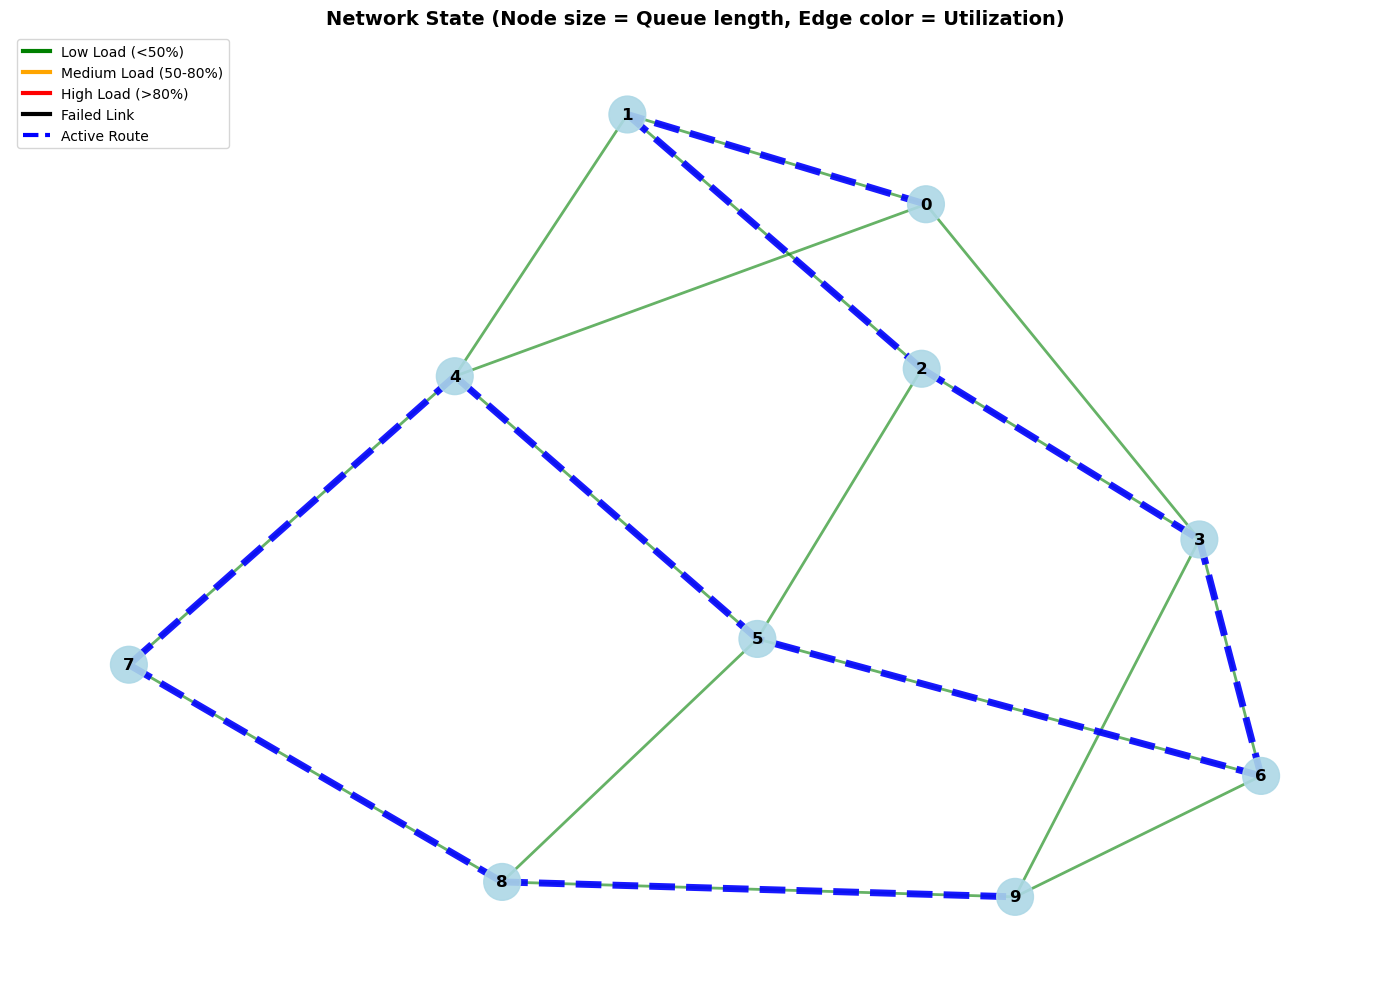


Scenario 2: Link Failure and Recovery

Simulating link failure (1 → 2)...
Packet 30: Rerouted via 0 → 1 → 4 → 7 → 8 → 9
Packet 31: Rerouted via 0 → 1 → 4 → 7 → 8 → 9
Packet 32: Rerouted via 0 → 1 → 4 → 7 → 8 → 9
Packet 33: Rerouted via 0 → 1 → 4 → 7 → 8 → 9
Packet 34: Rerouted via 0 → 1 → 4 → 7 → 8 → 9
Packet 35: Rerouted via 0 → 1 → 4 → 7 → 8 → 9
Packet 36: Rerouted via 0 → 1 → 4 → 7 → 8 → 9
Packet 37: Rerouted via 0 → 1 → 4 → 7 → 8 → 9
Packet 38: Rerouted via 0 → 1 → 4 → 7 → 8 → 9
Packet 39: Rerouted via 0 → 1 → 4 → 7 → 8 → 9

Restoring failed link...

Generating performance metrics...


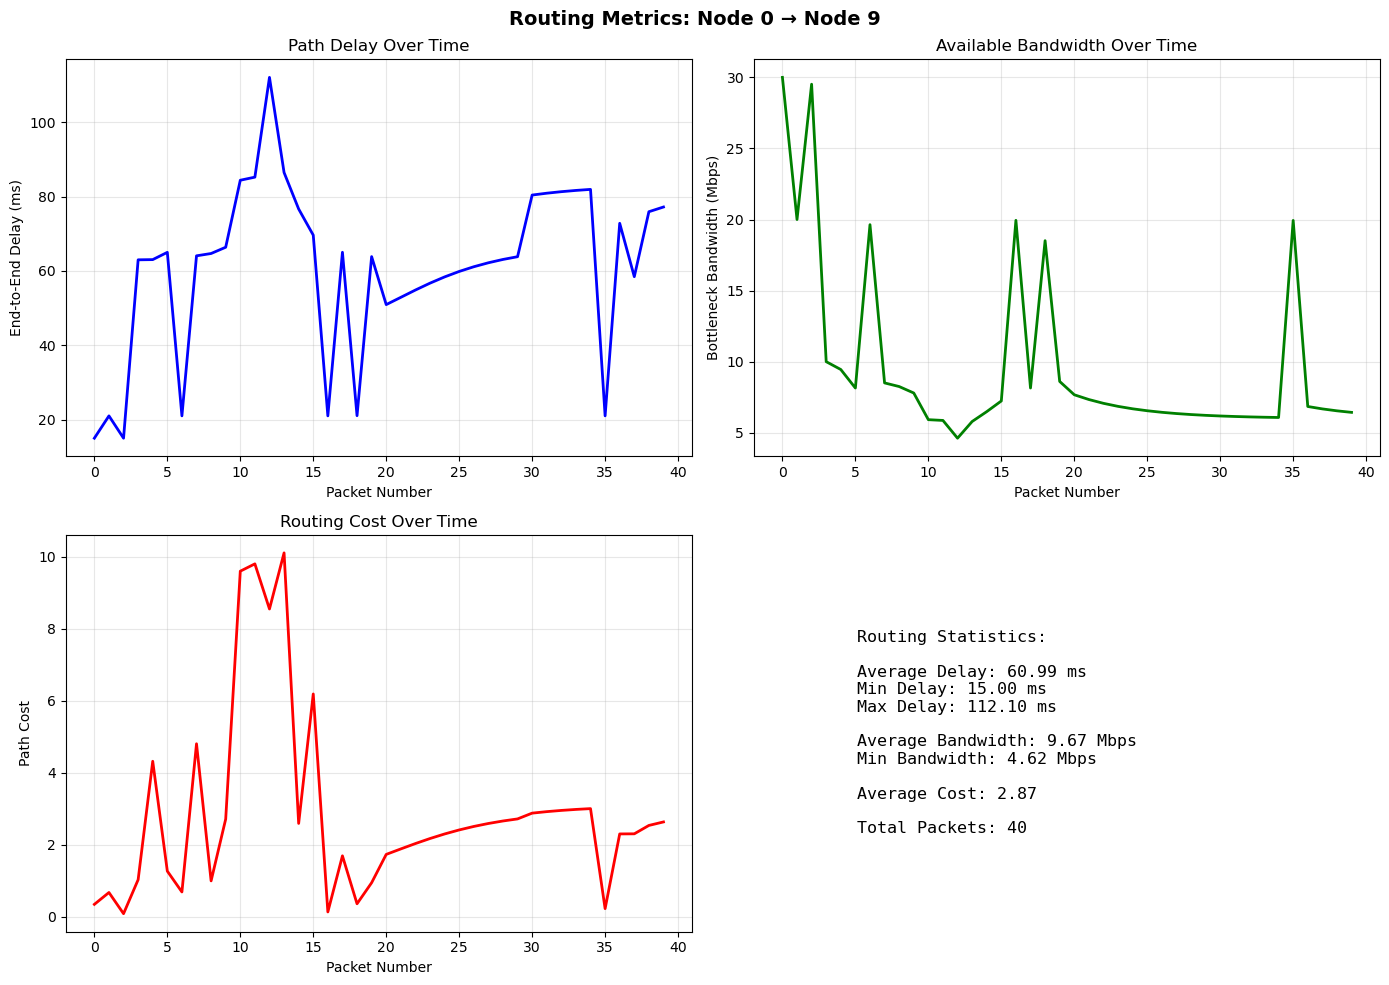


Simulation Complete!
Total packets routed: 40
Success rate: 80.0%


In [2]:
import random
import math
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import networkx as nx
import time

class NetworkLink:
    """Represents a network link with dynamic properties"""
    def __init__(self, bandwidth, base_delay, packet_loss=0.0):
        self.bandwidth = bandwidth  # Mbps
        self.base_delay = base_delay  # ms
        self.current_load = 0.0  # Current traffic load
        self.packet_queue = deque()
        self.packet_loss = packet_loss
        self.failed = False
        self.congestion_history = []
        
    def get_current_delay(self):
        """Calculate actual delay based on congestion"""
        if self.failed:
            return float('inf')
        
        # Delay increases exponentially with load
        utilization = self.current_load / self.bandwidth
        congestion_factor = 1 + (utilization ** 3) * 10  # Non-linear congestion
        return self.base_delay * congestion_factor
    
    def get_available_bandwidth(self):
        """Get currently available bandwidth"""
        if self.failed:
            return 0.0
        return max(0, self.bandwidth - self.current_load)
    
    def add_traffic(self, traffic_amount):
        """Add traffic to the link"""
        self.current_load = min(self.bandwidth * 1.2, self.current_load + traffic_amount)
    
    def decay_traffic(self, decay_rate=0.1):
        """Simulate traffic decay over time"""
        self.current_load = max(0, self.current_load * (1 - decay_rate))
        self.congestion_history.append(self.current_load / self.bandwidth)
        if len(self.congestion_history) > 100:
            self.congestion_history.pop(0)

class DataPacket:
    """Represents an actual data packet with requirements"""
    def __init__(self, packet_id, source, destination, size, priority=1, bandwidth_req=0):
        self.packet_id = packet_id
        self.source = source
        self.destination = destination
        self.size = size  # MB
        self.priority = priority  # 1-5, higher = more important
        self.bandwidth_req = bandwidth_req  # Minimum bandwidth required (Mbps)
        self.created_time = time.time()
        self.delivery_time = None
        self.path_taken = []
        self.hops = 0

class NetworkNode:
    """Represents a router with queuing and processing"""
    def __init__(self, node_id, processing_capacity=100):
        self.node_id = node_id
        self.pheromone_table = defaultdict(lambda: defaultdict(float))
        self.routing_table = defaultdict(lambda: defaultdict(float))
        self.neighbors = []
        self.packet_queue = deque()
        self.processing_capacity = processing_capacity  # packets/sec
        self.packets_processed = 0
        self.packets_dropped = 0
        
    def initialize_pheromones(self, destination, neighbors, initial_value=0.1):
        """Initialize pheromone values for a destination"""
        for neighbor in neighbors:
            self.pheromone_table[destination][neighbor] = initial_value
            self.routing_table[destination][neighbor] = 1.0 / len(neighbors)
    
    def get_queue_length(self):
        """Get current queue occupancy"""
        return len(self.packet_queue)

class NetworkGraph:
    """Represents the network topology with dynamic properties"""
    def __init__(self):
        self.nodes = {}
        self.links = {}
        self.traffic_matrix = defaultdict(lambda: defaultdict(float))
        self.active_flows = []
        
    def add_node(self, node_id, processing_capacity=100):
        """Add a node to the network"""
        if node_id not in self.nodes:
            self.nodes[node_id] = NetworkNode(node_id, processing_capacity)
            
    def add_link(self, node1, node2, bandwidth, delay, packet_loss=0.0):
        """Add a bidirectional link with capacity and delay"""
        self.add_node(node1)
        self.add_node(node2)
        
        self.links[(node1, node2)] = NetworkLink(bandwidth, delay, packet_loss)
        self.links[(node2, node1)] = NetworkLink(bandwidth, delay, packet_loss)
        
        if node2 not in self.nodes[node1].neighbors:
            self.nodes[node1].neighbors.append(node2)
        if node1 not in self.nodes[node2].neighbors:
            self.nodes[node2].neighbors.append(node1)
    
    def get_link(self, node1, node2):
        """Get link between two nodes"""
        return self.links.get((node1, node2))
    
    def simulate_link_failure(self, node1, node2):
        """Simulate a link failure"""
        if (node1, node2) in self.links:
            self.links[(node1, node2)].failed = True
            self.links[(node2, node1)].failed = True
    
    def restore_link(self, node1, node2):
        """Restore a failed link"""
        if (node1, node2) in self.links:
            self.links[(node1, node2)].failed = False
            self.links[(node2, node1)].failed = False
    
    def update_link_loads(self, decay_rate=0.1):
        """Update all link loads (simulate traffic decay)"""
        for link in self.links.values():
            link.decay_traffic(decay_rate)

class RoutingAnt:
    """Ant that explores routes while considering network state"""
    def __init__(self, source, destination, packet_size=1.0, bandwidth_req=0, priority=1):
        self.source = source
        self.destination = destination
        self.packet_size = packet_size
        self.bandwidth_req = bandwidth_req
        self.priority = priority
        self.path = [source]
        self.total_delay = 0.0
        self.total_cost = 0.0
        self.visited = {source}
        self.bottleneck_bandwidth = float('inf')
        self.feasible = True
        
    def calculate_link_cost(self, link, node_queue_length):
        """Calculate comprehensive cost for a link"""
        if link.failed:
            return float('inf')
        
        # Multiple factors influence cost
        delay_cost = link.get_current_delay()
        
        # Bandwidth availability factor
        available_bw = link.get_available_bandwidth()
        if available_bw < self.bandwidth_req:
            self.feasible = False
            return float('inf')
        
        bw_factor = 1.0 / (1.0 + available_bw) if available_bw > 0 else 10.0
        
        # Queue length factor (congestion at node)
        queue_factor = 1.0 + (node_queue_length * 0.1)
        
        # Packet loss factor
        loss_factor = 1.0 + (link.packet_loss * 5.0)
        
        # Combined cost with priority consideration
        cost = (delay_cost * bw_factor * queue_factor * loss_factor) / self.priority
        
        return cost
        
    def select_next_node(self, current_node, network, alpha=1.0, beta=2.0):
        """Select next node based on multiple QoS factors"""
        node = network.nodes[current_node]
        neighbors = node.neighbors
        
        # Filter out visited neighbors and failed links
        available_neighbors = []
        for n in neighbors:
            if n not in self.visited:
                link = network.get_link(current_node, n)
                if link and not link.failed:
                    available_neighbors.append(n)
        
        if not available_neighbors:
            return None
        
        # Calculate probabilities based on pheromone and link quality
        probabilities = []
        costs = []
        
        for neighbor in available_neighbors:
            # Pheromone level
            tau = node.pheromone_table[self.destination].get(neighbor, 0.1)
            
            # Link quality heuristic (inverse of cost)
            link = network.get_link(current_node, neighbor)
            next_node_obj = network.nodes[neighbor]
            cost = self.calculate_link_cost(link, next_node_obj.get_queue_length())
            costs.append(cost)
            
            if cost == float('inf'):
                probabilities.append(0)
            else:
                eta = 1.0 / cost
                # Combined probability
                prob = (tau ** alpha) * (eta ** beta)
                probabilities.append(prob)
        
        # Check if any feasible path exists
        if all(p == 0 for p in probabilities):
            return None
        
        # Normalize probabilities
        total = sum(probabilities)
        if total > 0:
            probabilities = [p / total for p in probabilities]
        else:
            return None
        
        # Select next node
        next_node = random.choices(available_neighbors, weights=probabilities)[0]
        return next_node
    
    def move_to(self, next_node, network):
        """Move ant to next node and update metrics"""
        current_node = self.path[-1]
        link = network.get_link(current_node, next_node)
        
        delay = link.get_current_delay()
        self.total_delay += delay
        
        # Track bottleneck bandwidth
        available_bw = link.get_available_bandwidth()
        self.bottleneck_bandwidth = min(self.bottleneck_bandwidth, available_bw)
        
        # Calculate comprehensive cost
        node = network.nodes[next_node]
        self.total_cost += self.calculate_link_cost(link, node.get_queue_length())
        
        self.path.append(next_node)
        self.visited.add(next_node)

class ACOPacketRouter:
    """Advanced ACO router with QoS awareness"""
    def __init__(self, network, alpha=1.0, beta=2.5, evaporation=0.15, 
                 q_constant=100, num_ants=15):
        self.network = network
        self.alpha = alpha
        self.beta = beta
        self.evaporation = evaporation
        self.q_constant = q_constant
        self.num_ants = num_ants
        self.initialize_pheromones()
        self.best_paths = {}
        self.path_metrics = defaultdict(list)
        self.packets_routed = 0
        self.packets_failed = 0
        
    def initialize_pheromones(self):
        """Initialize pheromone tables"""
        for node_id, node in self.network.nodes.items():
            for dest in self.network.nodes.keys():
                if dest != node_id:
                    node.initialize_pheromones(dest, node.neighbors)
    
    def send_ants(self, source, destination, packet_size=1.0, bandwidth_req=0, 
                  priority=1, num_ants=None):
        """Send ants to explore routes"""
        if num_ants is None:
            num_ants = self.num_ants
            
        successful_ants = []
        
        for _ in range(num_ants):
            ant = RoutingAnt(source, destination, packet_size, bandwidth_req, priority)
            current = source
            
            # Forward ant movement
            max_hops = len(self.network.nodes) * 2
            while current != destination and len(ant.path) < max_hops:
                next_node = ant.select_next_node(current, self.network, 
                                                 self.alpha, self.beta)
                if next_node is None:
                    break
                    
                ant.move_to(next_node, self.network)
                current = next_node
            
            # Check if ant reached destination successfully
            if current == destination and ant.feasible:
                successful_ants.append(ant)
        
        return successful_ants
    
    def update_pheromones(self, ants):
        """Update pheromones with quality-based deposition"""
        # Evaporation
        for node in self.network.nodes.values():
            for dest in node.pheromone_table:
                for neighbor in node.pheromone_table[dest]:
                    node.pheromone_table[dest][neighbor] *= (1 - self.evaporation)
        
        # Deposit pheromones based on path quality
        for ant in ants:
            # Better paths (lower cost, lower delay) get more pheromone
            quality_metric = self.q_constant / (ant.total_cost + 1.0)
            
            # Bonus for paths with good bandwidth
            if ant.bottleneck_bandwidth > 0:
                bw_bonus = min(2.0, ant.bottleneck_bandwidth / 10.0)
                quality_metric *= bw_bonus
            
            # Priority bonus
            quality_metric *= (ant.priority / 3.0)
            
            # Deposit along path
            for i in range(len(ant.path) - 1):
                current = ant.path[i]
                next_node = ant.path[i + 1]
                
                node = self.network.nodes[current]
                node.pheromone_table[ant.destination][next_node] += quality_metric
    
    def update_routing_tables(self):
        """Update routing probability tables"""
        for node in self.network.nodes.values():
            for dest in node.pheromone_table:
                neighbors = list(node.pheromone_table[dest].keys())
                if not neighbors:
                    continue
                    
                total_pheromone = sum(node.pheromone_table[dest].values())
                
                if total_pheromone > 0:
                    for neighbor in neighbors:
                        node.routing_table[dest][neighbor] = \
                            node.pheromone_table[dest][neighbor] / total_pheromone
    
    def route_packet(self, packet):
        """Route a data packet using current pheromone trails"""
        ants = self.send_ants(packet.source, packet.destination, 
                             packet.size, packet.bandwidth_req, packet.priority)
        
        if ants:
            self.update_pheromones(ants)
            self.update_routing_tables()
            
            # Select best path considering multiple factors
            best_ant = min(ants, key=lambda a: a.total_cost)
            
            # Update link loads along chosen path
            for i in range(len(best_ant.path) - 1):
                link = self.network.get_link(best_ant.path[i], best_ant.path[i + 1])
                link.add_traffic(packet.size)
            
            # Store path info
            key = (packet.source, packet.destination)
            self.best_paths[key] = (best_ant.path, best_ant.total_delay, 
                                   best_ant.bottleneck_bandwidth)
            self.path_metrics[key].append({
                'delay': best_ant.total_delay,
                'bandwidth': best_ant.bottleneck_bandwidth,
                'cost': best_ant.total_cost
            })
            
            packet.path_taken = best_ant.path
            packet.hops = len(best_ant.path) - 1
            packet.delivery_time = best_ant.total_delay
            
            self.packets_routed += 1
            return best_ant.path, best_ant.total_delay
        
        self.packets_failed += 1
        return None, None

def create_realistic_network():
    """Create a realistic network topology"""
    network = NetworkGraph()
    
    # Create a more complex network (ISP-like topology)
    # Format: (node1, node2, bandwidth_Mbps, delay_ms, packet_loss)
    links = [
        # Core routers (high bandwidth, low delay)
        (0, 1, 100, 2, 0.001),
        (1, 2, 100, 2, 0.001),
        (2, 3, 100, 3, 0.001),
        (0, 3, 80, 4, 0.002),
        
        # Distribution layer
        (1, 4, 50, 5, 0.01),
        (2, 5, 50, 5, 0.01),
        (3, 6, 50, 4, 0.01),
        (4, 5, 40, 6, 0.015),
        (5, 6, 40, 6, 0.015),
        
        # Access layer (lower bandwidth, higher delay)
        (4, 7, 20, 10, 0.02),
        (5, 8, 20, 12, 0.02),
        (6, 9, 20, 10, 0.02),
        (7, 8, 10, 15, 0.03),
        (8, 9, 10, 15, 0.03),
        
        # Backup paths
        (0, 4, 30, 8, 0.015),
        (3, 9, 30, 8, 0.015),
    ]
    
    for node1, node2, bw, delay, loss in links:
        network.add_link(node1, node2, bw, delay, loss)
    
    return network

def visualize_network_state(network, packets=None, highlight_path=None):
    """Visualize network with current state"""
    G = nx.Graph()
    
    # Add edges with current load info
    edge_colors = []
    edge_widths = []
    
    for (node1, node2), link in network.links.items():
        if node1 < node2:
            G.add_edge(node1, node2)
            # Color based on utilization
            utilization = link.current_load / link.bandwidth if link.bandwidth > 0 else 0
            
            if link.failed:
                edge_colors.append('black')
                edge_widths.append(1)
            elif utilization > 0.8:
                edge_colors.append('red')
                edge_widths.append(4)
            elif utilization > 0.5:
                edge_colors.append('orange')
                edge_widths.append(3)
            else:
                edge_colors.append('green')
                edge_widths.append(2)
    
    pos = nx.spring_layout(G, seed=42, k=0.5)
    
    plt.figure(figsize=(14, 10))
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, alpha=0.6)
    
    # Highlight specific path if provided
    if highlight_path:
        path_edges = [(highlight_path[i], highlight_path[i+1]) 
                     for i in range(len(highlight_path)-1)]
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, 
                              edge_color='blue', width=5, alpha=0.9, style='dashed')
    
    # Draw nodes with size based on queue length
    node_sizes = []
    for node_id in G.nodes():
        queue_len = network.nodes[node_id].get_queue_length()
        node_sizes.append(700 + queue_len * 50)
    
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                          node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], color='green', linewidth=3, label='Low Load (<50%)'),
        plt.Line2D([0], [0], color='orange', linewidth=3, label='Medium Load (50-80%)'),
        plt.Line2D([0], [0], color='red', linewidth=3, label='High Load (>80%)'),
        plt.Line2D([0], [0], color='black', linewidth=3, label='Failed Link'),
        plt.Line2D([0], [0], color='blue', linewidth=3, linestyle='dashed', label='Active Route')
    ]
    plt.legend(handles=legend_elements, loc='upper left', fontsize=10)
    
    plt.title("Network State (Node size = Queue length, Edge color = Utilization)", 
             fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def visualize_metrics(path_metrics, source, destination):
    """Visualize routing metrics over time"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    metrics = path_metrics[(source, destination)]
    iterations = range(len(metrics))
    
    delays = [m['delay'] for m in metrics]
    bandwidths = [m['bandwidth'] for m in metrics]
    costs = [m['cost'] for m in metrics]
    
    # Delay over time
    axes[0, 0].plot(iterations, delays, 'b-', linewidth=2)
    axes[0, 0].set_xlabel('Packet Number')
    axes[0, 0].set_ylabel('End-to-End Delay (ms)')
    axes[0, 0].set_title('Path Delay Over Time')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Bandwidth over time
    axes[0, 1].plot(iterations, bandwidths, 'g-', linewidth=2)
    axes[0, 1].set_xlabel('Packet Number')
    axes[0, 1].set_ylabel('Bottleneck Bandwidth (Mbps)')
    axes[0, 1].set_title('Available Bandwidth Over Time')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Cost over time
    axes[1, 0].plot(iterations, costs, 'r-', linewidth=2)
    axes[1, 0].set_xlabel('Packet Number')
    axes[1, 0].set_ylabel('Path Cost')
    axes[1, 0].set_title('Routing Cost Over Time')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Statistics
    axes[1, 1].axis('off')
    stats_text = f"""
    Routing Statistics:
    
    Average Delay: {sum(delays)/len(delays):.2f} ms
    Min Delay: {min(delays):.2f} ms
    Max Delay: {max(delays):.2f} ms
    
    Average Bandwidth: {sum(bandwidths)/len(bandwidths):.2f} Mbps
    Min Bandwidth: {min(bandwidths):.2f} Mbps
    
    Average Cost: {sum(costs)/len(costs):.2f}
    
    Total Packets: {len(metrics)}
    """
    axes[1, 1].text(0.1, 0.5, stats_text, fontsize=12, family='monospace',
                   verticalalignment='center')
    
    plt.suptitle(f'Routing Metrics: Node {source} → Node {destination}', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Main simulation
if __name__ == "__main__":
    print("=" * 70)
    print("Advanced Ant Colony Optimization for Dynamic Network Packet Routing")
    print("=" * 70)
    
    # Create network
    network = create_realistic_network()
    print(f"\nNetwork created with {len(network.nodes)} nodes")
    print(f"Total links: {len(network.links) // 2}")
    
    # Initialize ACO router
    router = ACOPacketRouter(
        network=network,
        alpha=1.0,
        beta=2.5,
        evaporation=0.15,
        q_constant=100,
        num_ants=15
    )
    
    print("\n" + "=" * 70)
    print("Scenario 1: Normal Traffic")
    print("=" * 70)
    
    # Simulate packet routing
    source = 0
    destination = 9
    num_packets = 30
    
    print(f"\nRouting {num_packets} packets: Node {source} → Node {destination}")
    
    for i in range(num_packets):
        # Create packet with varying requirements
        priority = random.randint(1, 5)
        size = random.uniform(0.5, 3.0)  # MB
        bandwidth_req = random.uniform(0, 10)  # Mbps
        
        packet = DataPacket(i, source, destination, size, priority, bandwidth_req)
        path, delay = router.route_packet(packet)
        
        # Decay traffic on all links
        network.update_link_loads(decay_rate=0.2)
        
        if i % 10 == 0 and path:
            print(f"Packet {i}: Path = {' → '.join(map(str, path))}, "
                  f"Delay = {delay:.2f}ms, Priority = {priority}")
    
    print(f"\nPackets successfully routed: {router.packets_routed}")
    print(f"Packets failed: {router.packets_failed}")
    
    # Visualize current state
    best_path, _, _ = router.best_paths.get((source, destination), (None, None, None))
    print("\nGenerating network state visualization...")
    visualize_network_state(network, highlight_path=best_path)
    
    print("\n" + "=" * 70)
    print("Scenario 2: Link Failure and Recovery")
    print("=" * 70)
    
    # Simulate link failure
    print("\nSimulating link failure (1 → 2)...")
    network.simulate_link_failure(1, 2)
    
    for i in range(10):
        packet = DataPacket(num_packets + i, source, destination, 1.0, 3, 5)
        path, delay = router.route_packet(packet)
        network.update_link_loads(decay_rate=0.2)
        
        if path:
            print(f"Packet {num_packets + i}: Rerouted via {' → '.join(map(str, path))}")
    
    print("\nRestoring failed link...")
    network.restore_link(1, 2)
    
    for i in range(10):
        packet = DataPacket(num_packets + 10 + i, source, destination, 1.0, 3, 5)
        path, delay = router.route_packet(packet)
        network.update_link_loads(decay_rate=0.2)
    
    # Final visualizations
    print("\nGenerating performance metrics...")
    visualize_metrics(router.path_metrics, source, destination)
    
    print("\n" + "=" * 70)
    print("Simulation Complete!")
    print("=" * 70)
    print(f"Total packets routed: {router.packets_routed}")
    print(f"Success rate: {(router.packets_routed/(router.packets_routed + router.packets_failed)*100):.1f}%")